In [ ]:
#Montar o Google Drive
import os
from google.colab import drive
os.system('drive.mount("/content/drive", force_remount=True) > /dev/null 2>&1');

Dados da Bancada 5

https://drive.google.com/drive/folders/18rsgFhkFybC4cmBa4rnA0ORyyjJZEL8x?usp=sharing

In [ ]:
!pip install -q control

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import control as ct
import scipy.signal as sg
from control.matlab import *

# ENSAIO DE ONDA QUADRADA: SISTENA CONTÍNUO DE PRIMEIRA ORDEM:

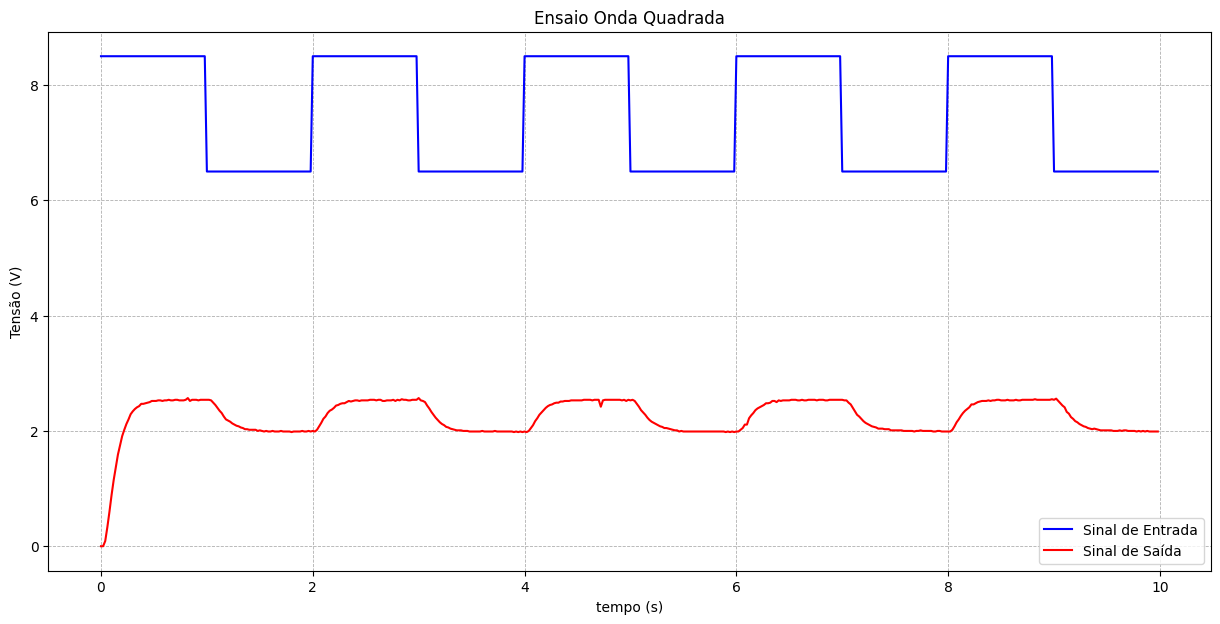

In [ ]:
dados_Continuo = np.load(r"/content/drive/MyDrive/Bancada_5/Dados_Coletados/Dados_Coletados_Continuo.np.npy")

tempo_Continuo = dados_Continuo[:,0]
sinal_entrada_Continuo  = dados_Continuo[:,1]
sinal_saida_Continuo = dados_Continuo[:,2]

plt.figure(figsize=(15,7))
plt.plot(tempo_Continuo,sinal_entrada_Continuo, c = 'b', label = "Sinal de Entrada")
plt.plot(tempo_Continuo,sinal_saida_Continuo, c = 'r', label = "Sinal de Saída")

plt. title('Ensaio Onda Quadrada')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)
plt.show()

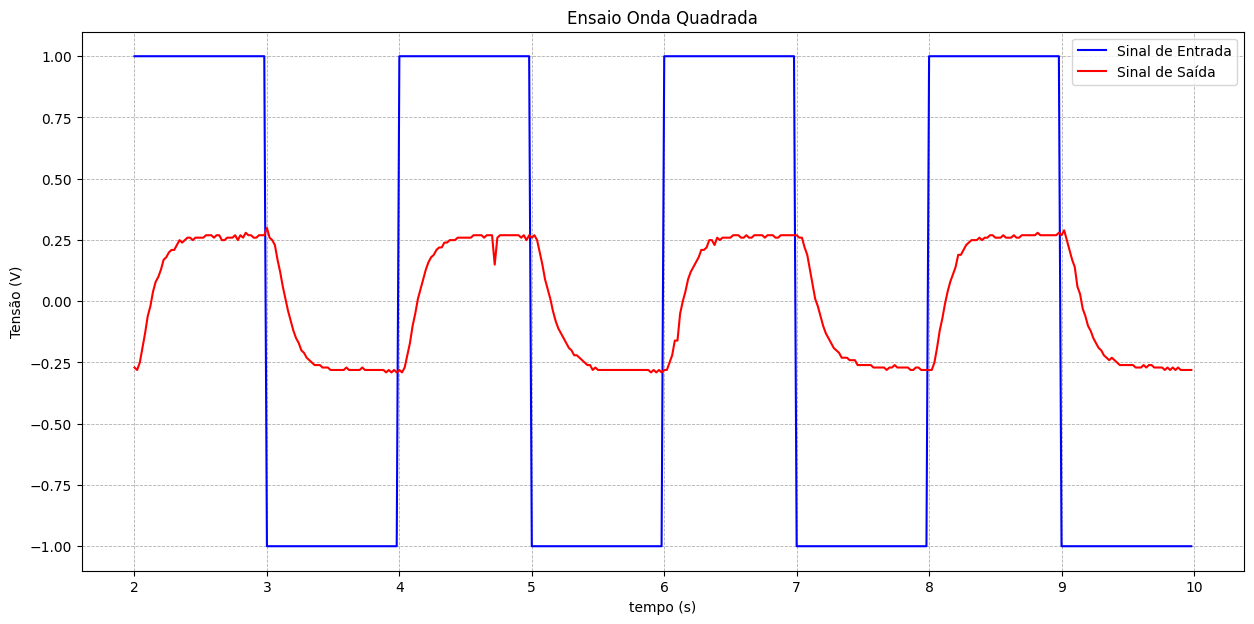


 Nivel DC entrada do Contínuo: 7.5
 Nivel DC saída do Contínuo: 2.271


In [ ]:
# ________________ Define janela que despreza os primeiros instantes do ensaio __________#

janela_Continuo = (tempo_Continuo>2) & (tempo_Continuo<14)

nivel_dc_entrada_Continuo = np.mean(sinal_entrada_Continuo[janela_Continuo])

nivel_dc_saida_Continuo = np.mean(sinal_saida_Continuo[janela_Continuo])

# ________________ Remove Nivel DC da Entrada e da Saída __________#

r_Continuo = sinal_entrada_Continuo - nivel_dc_entrada_Continuo
y_Continuo = sinal_saida_Continuo - nivel_dc_saida_Continuo

plt.figure(figsize=(15,7))
plt.plot(tempo_Continuo[janela_Continuo],r_Continuo[janela_Continuo], c = 'b', label = "Sinal de Entrada")
plt.plot(tempo_Continuo[janela_Continuo],y_Continuo[janela_Continuo], c = 'r', label = "Sinal de Saída")

plt. title('Ensaio Onda Quadrada')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)
plt.show()

print("\n Nivel DC entrada do Contínuo:" , np.round(nivel_dc_entrada_Continuo,3))
print(" Nivel DC saída do Contínuo:" , np.round(nivel_dc_saida_Continuo,3))

Apartir dos dados de saida do sistema podemos determinar o Ganho do sistema e a constante de tempo.

Para reliazar esta analise vamos usar apenas um periodo do sinal de saida e coletar os valores de maximo e minimo.

Realizar a análise para apenas um período do sinal;

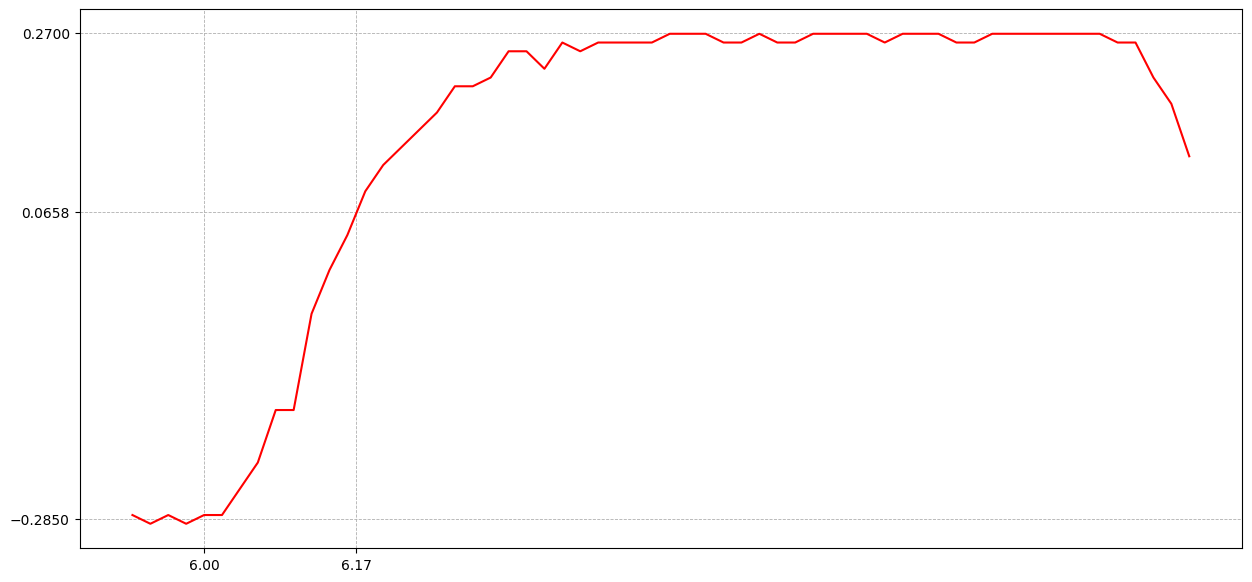

In [ ]:
# ________________ Define o intervalo de tempo entre os instantes 5.9 e 7.1 segundos __________#
index = (tempo_Continuo>5.9)&(tempo_Continuo<7.1)

plt.figure(figsize=(15,7))
plt.plot(tempo_Continuo[index],y_Continuo[index],'r')
plt.yticks([-0.285,0.0658,0.27])
plt.xticks([6,6.17])
plt.grid(linestyle='--', linewidth=0.6)
plt.show()

In [ ]:
Km_Continuo = (0.27 - (-0.285) )/ 2

y6321_Continuo = (0.6321*(0.27 - (-0.285))) - 0.285
tau_Continuo = 6.17-6.0

print(" Km =", round(Km_Continuo,3))
print(" Tau =", round(tau_Continuo,3))

 Km = 0.277
 Tau = 0.17


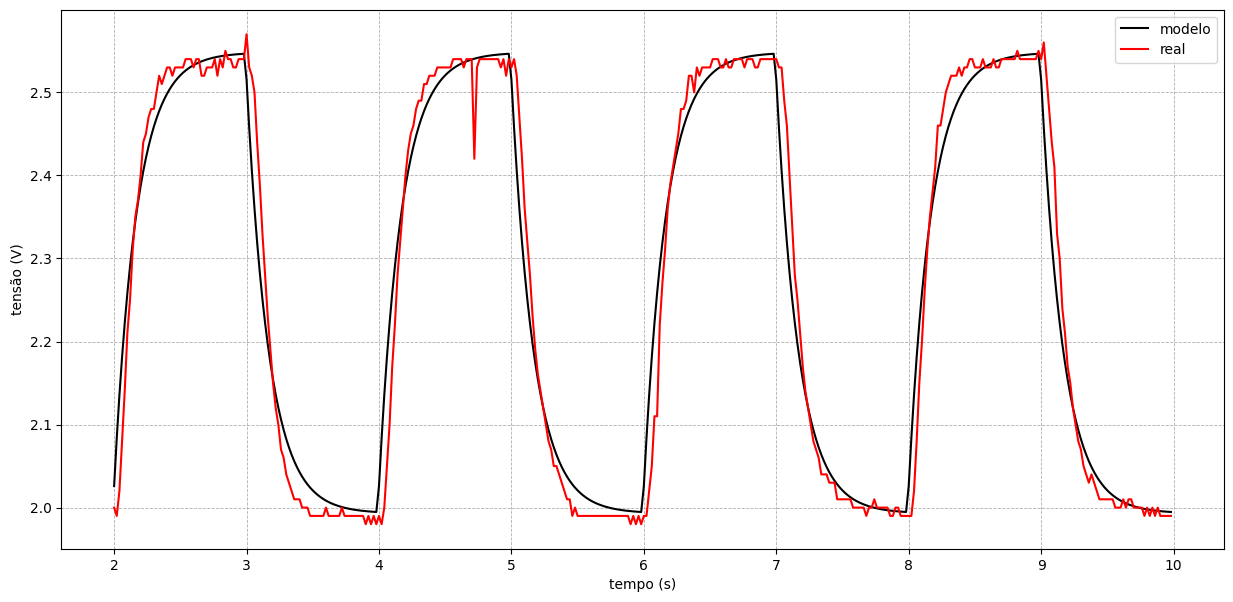


 Erro RMS: 2.2709693425747974


In [ ]:
# ________________ Simulação do Modelo Determinado __________#
num_Continuo = [Km_Continuo]
den_Continuo = [abs(tau_Continuo), 1]

G_Continuo = ct.tf(num_Continuo,den_Continuo)
_,ym_Continuo = ct.forced_response(G_Continuo,T = tempo_Continuo, U = r_Continuo)

plt.figure(figsize=(15,7))
plt.plot(tempo_Continuo[janela_Continuo], ym_Continuo[janela_Continuo] + nivel_dc_saida_Continuo ,'k', label = 'modelo')
plt.plot(tempo_Continuo[janela_Continuo], sinal_saida_Continuo[janela_Continuo] ,'r', label = 'real')
plt.xlabel('tempo (s)')
plt.ylabel('tensão (V)')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)
plt.show()

erro_rms_Continuo = (np.sum((ym_Continuo[janela_Continuo] - sinal_saida_Continuo[janela_Continuo])**2)/np.size(sinal_saida_Continuo[janela_Continuo]))
print("\n Erro RMS:", np.sqrt(erro_rms_Continuo))

In [ ]:
#Algumas informaões sobre o sistema:
print('\n')
print("Sistema em Malha Aberta: \n", G_Continuo)
ct.damp(G_Continuo)
print('\n')
ct.step_info(G_Continuo)



Sistema em Malha Aberta: 
 
  0.2775
----------
0.17 s + 1

    Eigenvalue (pole)       Damping     Frequency
               -5.882             1         5.882




{'RiseTime': 0.37957766381477587,
 'SettlingTime': 0.6761227136700695,
 'SettlingMin': 0.25162025712399055,
 'SettlingMax': 0.27749999999999997,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 0.2772224999999998,
 'PeakTime': 1.1743183974269629,
 'SteadyStateValue': 0.27749999999999997}

# **Controlador P**

In [ ]:
#Calculando o Kp para redução de 15% no Tempo de subida:
Ts_Continuo = ct.step_info(G_Continuo)['RiseTime']

Ts_mf_Continuo = Ts_Continuo * 0.85

tau_mf_Continuo = Ts_mf_Continuo / 2.2

Kp_Continuo = (tau_Continuo / tau_mf_Continuo - 1) / Km_Continuo

#Calculamdo o ganho DC
ganho_Continuo = (Km_Continuo * Kp_Continuo) / ( 1 + Kp_Continuo * Km_Continuo)

print(" Ts em malha fechada =", round(Ts_mf_Continuo, 3))
print(" Tau em malha fechada =", round(tau_mf_Continuo,3))
print("\n Ganho proporcional: Kp =", Kp_Continuo)
print(" Ganho DC =", round(ganho_Continuo, 3))

 Ts em malha fechada = 0.323
 Tau em malha fechada = 0.147

 Ganho proporcional: Kp = 0.5736326690747333
 Ganho DC = 0.137


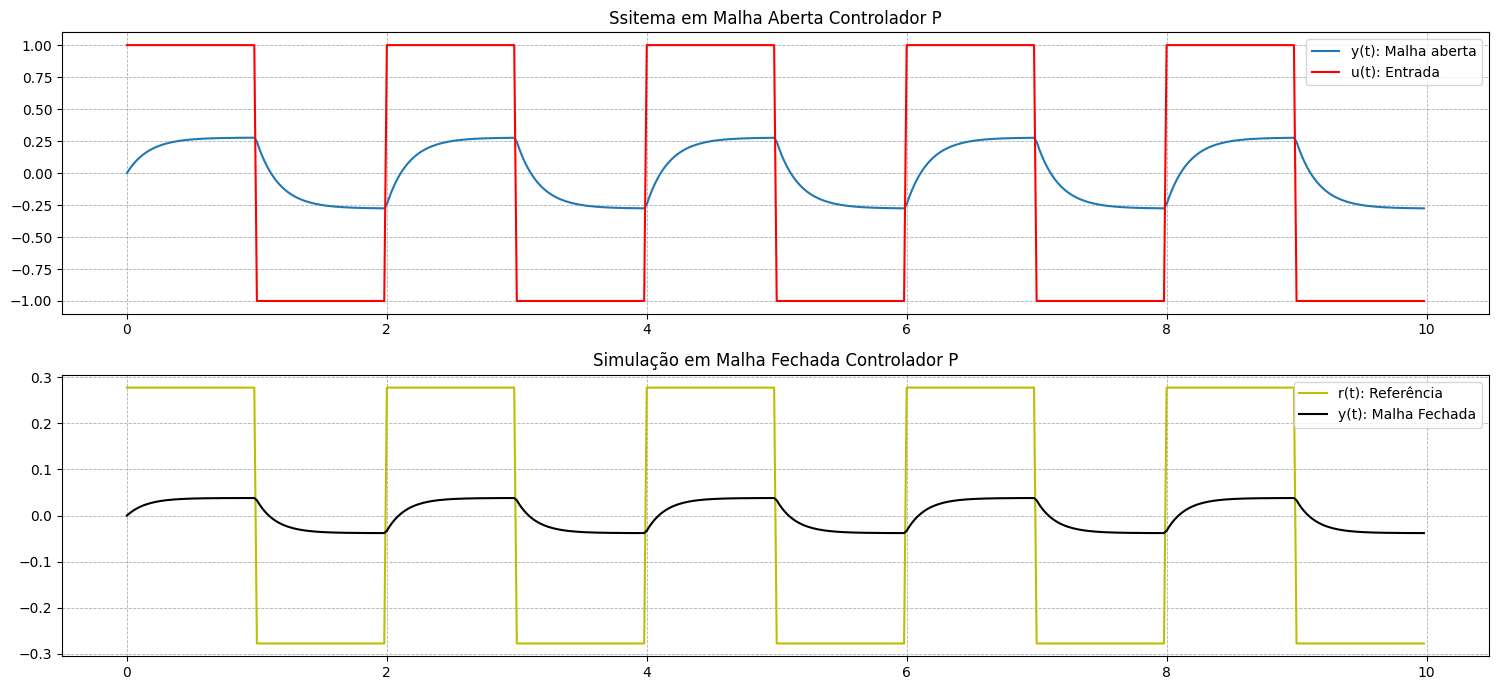


 Função de transferência em Malha Fechada:  
    0.1592
--------------
0.17 s + 1.159

    Eigenvalue (pole)       Damping     Frequency
               -6.819             1         6.819




{'RiseTime': 0.3172198358579243,
 'SettlingTime': 0.5832751820613448,
 'SettlingMin': 0.12359114219704921,
 'SettlingMax': 0.13732349133005461,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 0.13718616783872448,
 'PeakTime': 1.0130568951591776,
 'SteadyStateValue': 0.13732349133005461}

In [ ]:
#Simulação do sistema em malha fechada
Hmf_p_Continuo = ct.feedback(Kp_Continuo * G_Continuo, 1)

#Definindo um sinal de referência
sinal_rf_Continuo = Km_Continuo * (sinal_entrada_Continuo - nivel_dc_entrada_Continuo)

#Plot do sistema para onda quadrada
_, y_mf_Continuo = ct.forced_response(Hmf_p_Continuo, T = tempo_Continuo, U = sinal_rf_Continuo)
plt.figure(figsize=(15,7))

plt.subplot(2,1,1)
plt.plot(tempo_Continuo, ym_Continuo, label ="y(t): Malha aberta")
plt.plot(tempo_Continuo, sinal_entrada_Continuo - nivel_dc_entrada_Continuo, '-r', label ="u(t): Entrada")
plt.title('Ssitema em Malha Aberta Controlador P')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)

plt.subplot(2,1,2)
plt.plot(tempo_Continuo, sinal_rf_Continuo,'y', label ="r(t): Referência")
plt.plot(tempo_Continuo, y_mf_Continuo,'-k', label = "y(t): Malha Fechada")
plt.title('Ssitema em Malha Fechada')
plt.title('Simulação em Malha Fechada Controlador P')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.show()

#Informações sobre o sistema
print("\n Função de transferência em Malha Fechada: ", Hmf_p_Continuo)
ct.damp(Hmf_p_Continuo)
print("\n")
ct.step_info(Hmf_p_Continuo)

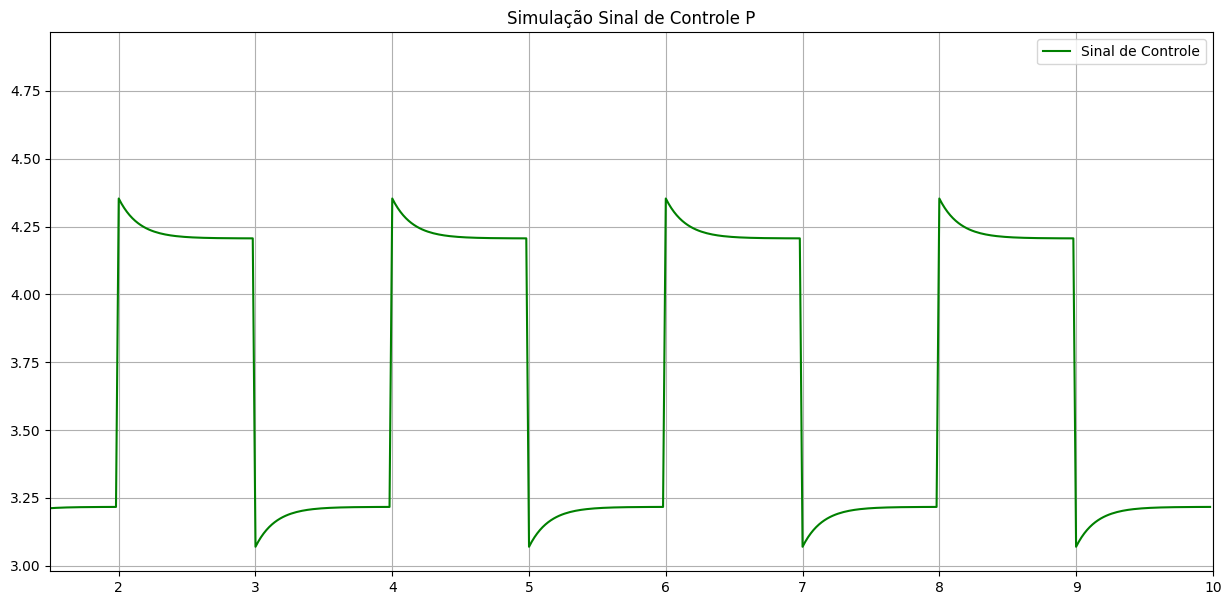


 Controlador_Contínuo: 
 
0.09752 s + 0.5736
------------------
  0.17 s + 1.159



In [ ]:
## ______________ Sinal de Controle _______________##
C_Continuo = ct.feedback(Kp_Continuo, G_Continuo, sign =-1)

## ________ Simulação para obter o Sinal de Controle __________##

_, sinal_controle_Continuo = ct.forced_response(C_Continuo, T = tempo_Continuo, U = sinal_entrada_Continuo)
nivel_dc_controle_Continuo = np.mean(sinal_controle_Continuo)

## ________ Simulação do Sistema para Onda Quadrada __________##

plt.figure(figsize=(15,7))
plt.plot(tempo_Continuo, sinal_controle_Continuo, '-g', label= "Sinal de Controle")
plt.title('Simulação Sinal de Controle P')
plt.xlim(1.5, 10)
plt.legend()
plt.grid()
plt.show()

print('\n Controlador_Contínuo: \n', C_Continuo)

**SINAL OBTIDO DO CONTROLADOR P CONTÍNUO**

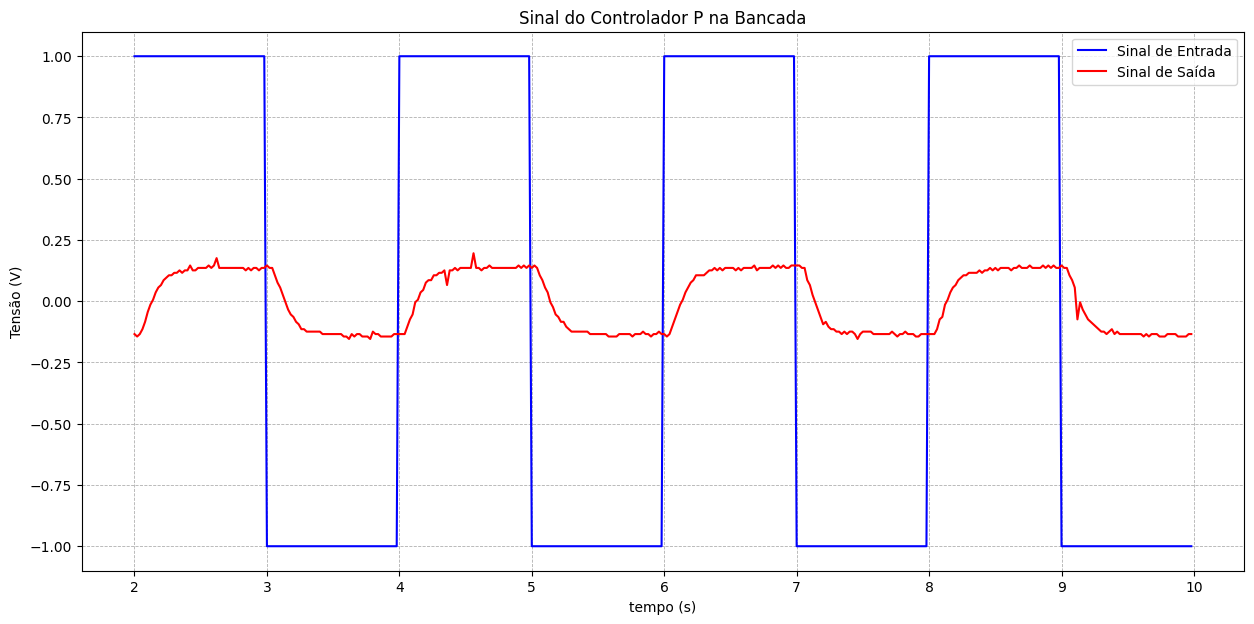

In [ ]:
dados_Continuo_P = np.load(r'/content/drive/MyDrive/Bancada_5/Dados_dos_Controladores/Dados_Controlador_P_Continuo.npy')

tempo_Continuo_P = dados_Continuo_P[:,0]
sinal_entrada_Continuo_P  = dados_Continuo_P[:,1]
sinal_saida_Continuo_P = dados_Continuo_P[:,2]

nivel_dc_entrada_Continuo_P = np.mean(sinal_entrada_Continuo_P[janela_Continuo])

nivel_dc_saida_Continuo_P = np.mean(sinal_saida_Continuo_P[janela_Continuo])

# ________________ Remove Nivel DC da Entrada e da Saída __________#

r_Continuo_P = sinal_entrada_Continuo_P - nivel_dc_entrada_Continuo_P
y_Continuo_P = sinal_saida_Continuo_P - nivel_dc_saida_Continuo_P

plt.figure(figsize=(15,7))
plt.plot(tempo_Continuo_P[janela_Continuo],r_Continuo_P[janela_Continuo], c = 'b', label = "Sinal de Entrada")
plt.plot(tempo_Continuo_P[janela_Continuo],y_Continuo_P[janela_Continuo], c = 'r', label = "Sinal de Saída")

plt. title('Sinal do Controlador P na Bancada')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)
plt.show()

# **Controlador PI**

In [ ]:
# Calculando o Tempo de subida reduzido em 15%
Ts_mf = 0.37*0.85
wn = 1.8/Ts_mf

Tr = ct.step_info(G_Continuo)['SettlingTime']
qsi = 4/(0.8*wn)

K_Continuo = Km_Continuo
b_Continuo = 1/tau_Continuo

Kc_Continuo = (((2*qsi*wn)/b_Continuo)-1)/K_Continuo

a_Continuo=  (wn**2)/(Kc_Continuo * K_Continuo * b_Continuo)

Gc_Continuo = ct.tf([Kc_Continuo, Kc_Continuo * a_Continuo],[1,0])

H_pi_Continuo = ct.feedback(Gc_Continuo * G_Continuo, 1, sign = -1)

print("Frequencia natural:", round(wn,3))
print("Fator de amortecimento: ", round(qsi,3))

print('\nGanho do Controlador PI:', round(Kc_Continuo,3), '\nZero do PI:', round(a_Continuo,3))
print("\nSistema em Malha Fechada H(s)")
display(H_pi_Continuo)

print("\nControlador Gc(s): ")
display(Gc_Continuo)

Frequencia natural: 5.723
Fator de amortecimento:  0.874

Ganho do Controlador PI: 2.523 
Zero do PI: 7.955

Sistema em Malha Fechada H(s)


TransferFunction(array([0.7       , 5.56868474]), array([0.17      , 1.7       , 5.56868474]))


Controlador Gc(s): 


TransferFunction(array([ 2.52252252, 20.0673324 ]), array([1, 0]))

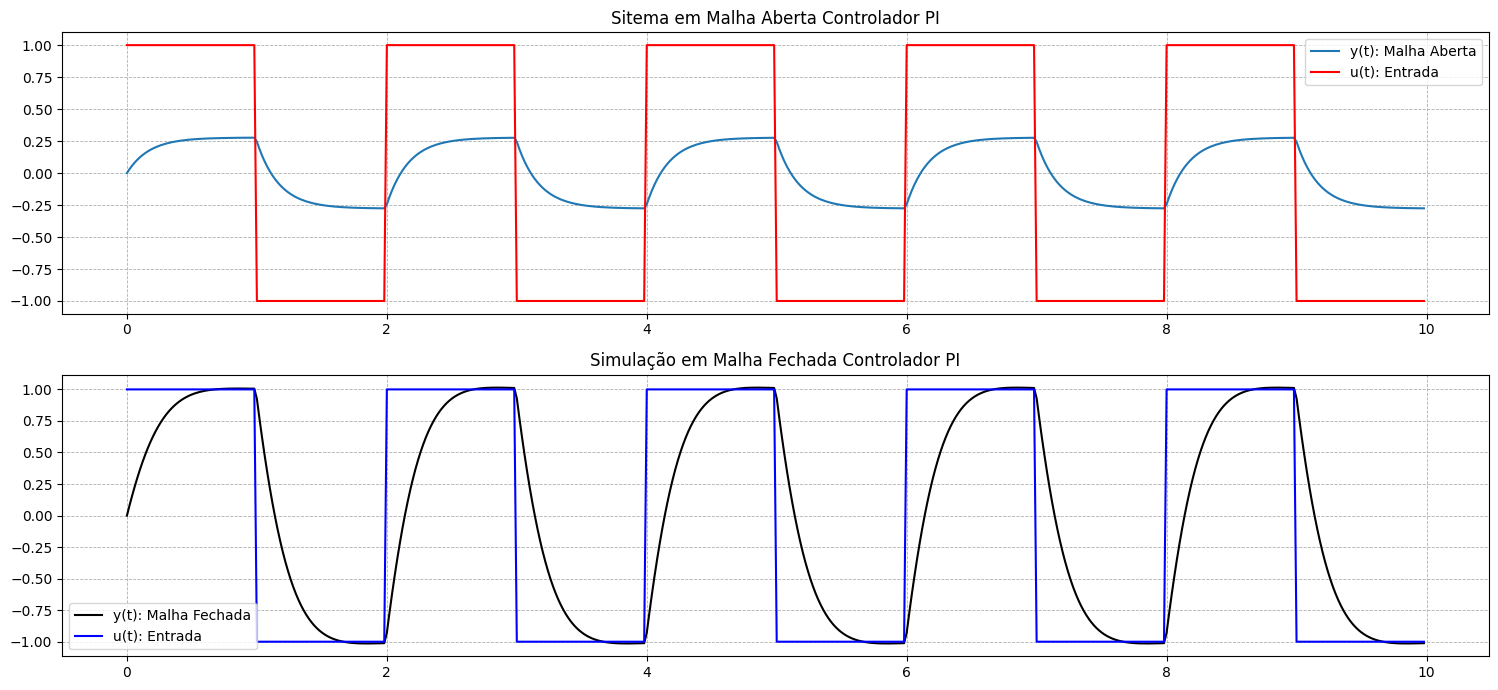

In [ ]:
C_pi_Continuo = ct.feedback(Gc_Continuo, G_Continuo, sign = -1)

_, ymf_pi_Continuo = ct.forced_response(H_pi_Continuo, T = tempo_Continuo, U = r_Continuo)

plt.figure(figsize=(15,7))

plt.subplot(2,1,1)
plt.plot(tempo_Continuo, ym_Continuo, label ="y(t): Malha Aberta")
plt.plot(tempo_Continuo, sinal_entrada_Continuo - nivel_dc_entrada_Continuo, '-r', label ="u(t): Entrada")
plt.title('Sitema em Malha Aberta Controlador PI')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)

plt.subplot(2, 1, 2)
plt.plot(tempo_Continuo, ymf_pi_Continuo, 'k', label ="y(t): Malha Fechada")
plt.plot(tempo_Continuo, r_Continuo, 'b', label ="u(t): Entrada")
plt.title("Simulação em Malha Fechada Controlador PI")
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.show()

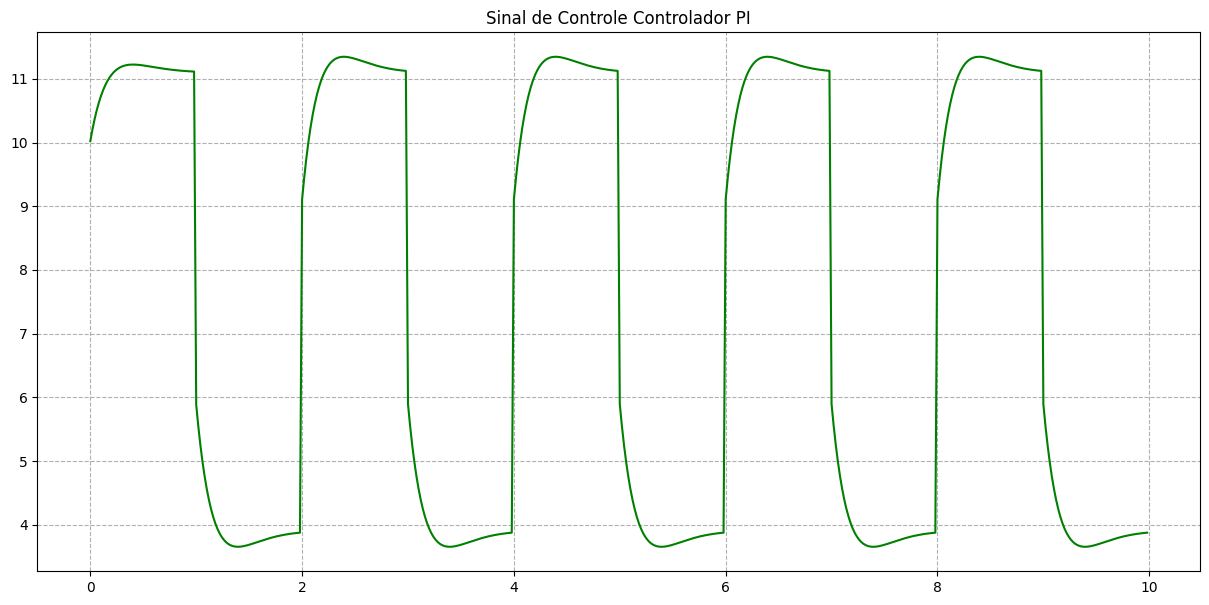

In [ ]:
_, u_pi_Continuo = ct.forced_response(C_pi_Continuo,T = tempo_Continuo, U = r_Continuo)

plt.figure(figsize=(15,7))
plt.plot(tempo_Continuo, u_pi_Continuo+7.5, 'g')
plt.title("Sinal de Controle Controlador PI")
plt.grid(linestyle='--')
plt.show()

In [ ]:
#Discretizando o controlador

dt = 0.02
ct.c2d(Gc_Continuo, dt, 'tustin')

TransferFunction(array([ 2.72319585, -2.3218492 ]), array([ 1., -1.]), 0.02)

**SINAL OBTIDO DO CONTROLADOR PI CONTÍNUO**

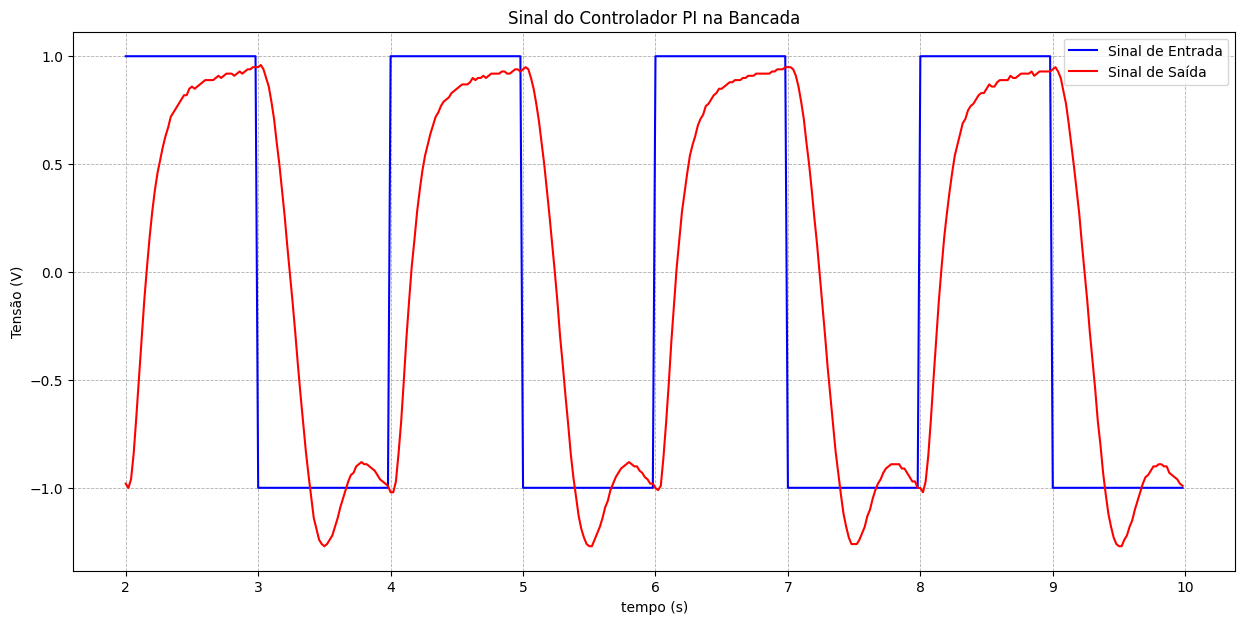

In [ ]:
dados_Continuo_PI = np.load(r'/content/drive/MyDrive/Bancada_5/Dados_dos_Controladores/Dados_Controlador_PI_Continuo.np.npy')

tempo_Continuo_PI = dados_Continuo_PI[:,0]
sinal_entrada_Continuo_PI  = dados_Continuo_PI[:,1]
sinal_saida_Continuo_PI = dados_Continuo_PI[:,2]

nivel_dc_entrada_Continuo_PI = np.mean(sinal_entrada_Continuo_PI[janela_Continuo])

nivel_dc_saida_Continuo_PI = np.mean(sinal_saida_Continuo_PI[janela_Continuo])

# ________________ Remove Nivel DC da Entrada e da Saída __________#

r_Continuo_PI = sinal_entrada_Continuo_PI - nivel_dc_entrada_Continuo_PI
y_Continuo_PI = sinal_saida_Continuo_PI - nivel_dc_saida_Continuo_PI

plt.figure(figsize=(15,7))
plt.plot(tempo_Continuo_PI[janela_Continuo],r_Continuo_PI[janela_Continuo], c = 'b', label = "Sinal de Entrada")
plt.plot(tempo_Continuo_PI[janela_Continuo],y_Continuo_PI[janela_Continuo], c = 'r', label = "Sinal de Saída")

plt. title('Sinal do Controlador PI na Bancada')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)
plt.show()

#PRBS: SITEMA DE SEGUNDA ORDEM

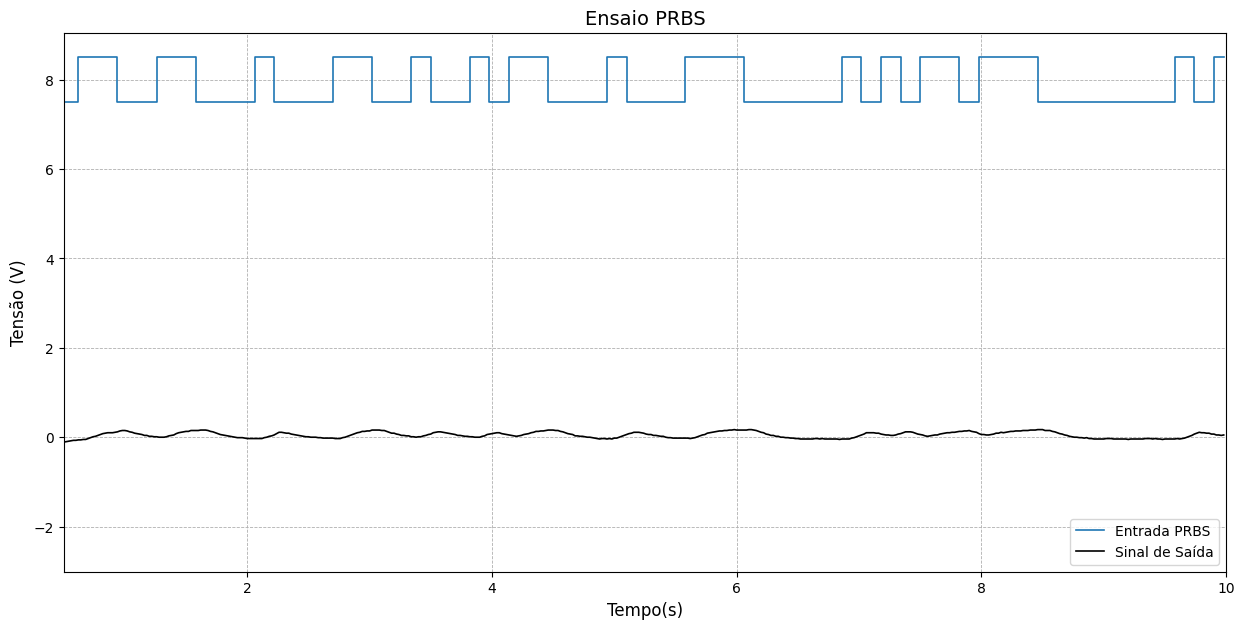

 Nivel DC entrada= 7.876 
 Nivel DC de saída 2.457


In [ ]:
dados_PRBS = pd.read_csv("/content/drive/MyDrive/Bancada_5/Dados_Coletados/Dados_Coletados_PRBS.csv", header=None, sep=";").values

tempo_PRBS = dados_PRBS[:,0]
sinal_entrada_PRBS  = dados_PRBS[:,1]
sinal_saida_PRBS = dados_PRBS[:,2]

nivel_dc_entrada_PRBS = np.mean(sinal_entrada_PRBS)
nivel_dc_saida_PRBS = np.mean(sinal_saida_PRBS)
r_PRBS = sinal_entrada_PRBS - nivel_dc_entrada_PRBS
y_PRBS = sinal_saida_PRBS - nivel_dc_saida_PRBS


plt.figure(figsize=(15,7))
plt.plot(tempo_PRBS,sinal_entrada_PRBS, drawstyle="steps", linewidth=1.2)
plt.plot(tempo_PRBS,y_PRBS, color='k',linewidth=1.2)

plt.xlabel('Tempo(s)', fontsize=12)
plt.ylabel('Tensão (V)', fontsize=12)
plt.xlim(0.5, 10)
plt.title('Ensaio PRBS', fontsize=14)
plt.legend(loc='lower right', labels=('Entrada PRBS','Sinal de Saída'))
plt.grid(linestyle='--', linewidth=0.6)
plt.show()

print(' Nivel DC entrada=', np.round(nivel_dc_entrada_PRBS,3),'\n Nivel DC de saída',np.round(nivel_dc_saida_PRBS,3))

In [ ]:
# Vetores de tempo
intervalo_train_PRBS = np.arange(50,250)
intervalo_test_PRBS = np.arange(250,499)

t_train_PRBS = dados_PRBS[intervalo_train_PRBS,0]
t_test_PRBS = dados_PRBS[intervalo_test_PRBS,0]

# Vetores da entrada
xtrain_PRBS, xtest_PRBS = dados_PRBS[intervalo_train_PRBS,1], dados_PRBS[intervalo_test_PRBS,1]

# Vetores da saída
ytrain_PRBS, ytest_PRBS = dados_PRBS[intervalo_train_PRBS,2], dados_PRBS[intervalo_test_PRBS,2]

# Variável tempo discreto (amostras)
k_PRBS = np.arange(1, len(xtrain_PRBS))

# Matriz de Regressores (Primeira Ordem)
PSI_PRBS = np.array([-ytrain_PRBS[k_PRBS - 1], xtrain_PRBS[k_PRBS - 1]]).T

# Calculo dos coeficientes
teta_PRBS = np.linalg.inv(PSI_PRBS.T @ PSI_PRBS) @ PSI_PRBS.T @ ytrain_PRBS[k_PRBS]

# Separando os coeficientes
a1_PRBS, b1_PRBS = teta_PRBS

# Numerador de H(z)
B_PRBS = [b1_PRBS]

# Denominador de H(z)
A_PRBS = [1, a1_PRBS]

# Período de amostragem em segundos
Ts_PRBS = np.mean(np.diff(tempo_PRBS))

# Função de transferência pulsada
Gz_PRBS = ct.tf(B_PRBS, A_PRBS, Ts_PRBS)

print('G(z)= \n', Gz_PRBS)

G(z)= 
 
 0.01567
----------
z - 0.9507

dt = 0.01999999999999975



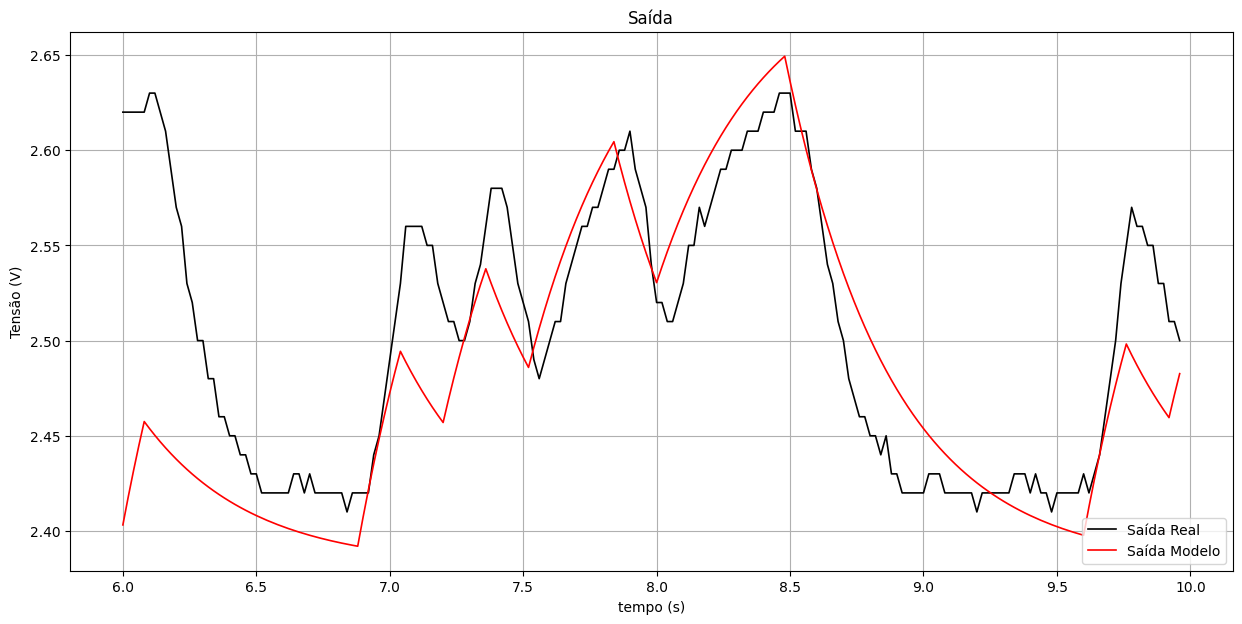

In [ ]:
# Respostas da função de transferência para a entrada de validação.
y_hat_PRBS = ct.forced_response(Gz_PRBS, U=xtest_PRBS)[1]

plt.figure(figsize=(15,7))
plt.plot(t_test_PRBS[50:], ytest_PRBS[50:], '-k', linewidth=1.2)
plt.plot(t_test_PRBS[50:], y_hat_PRBS[50:], '-r', linewidth=1.2)
plt.xlabel('tempo (s)')
plt.ylabel('Tensão (V)')
plt.title('Saída')
plt.legend(loc='lower right', labels=('Saída Real', 'Saída Modelo'))
plt.grid()

plt.subplots_adjust(hspace=0.5)
plt.show()

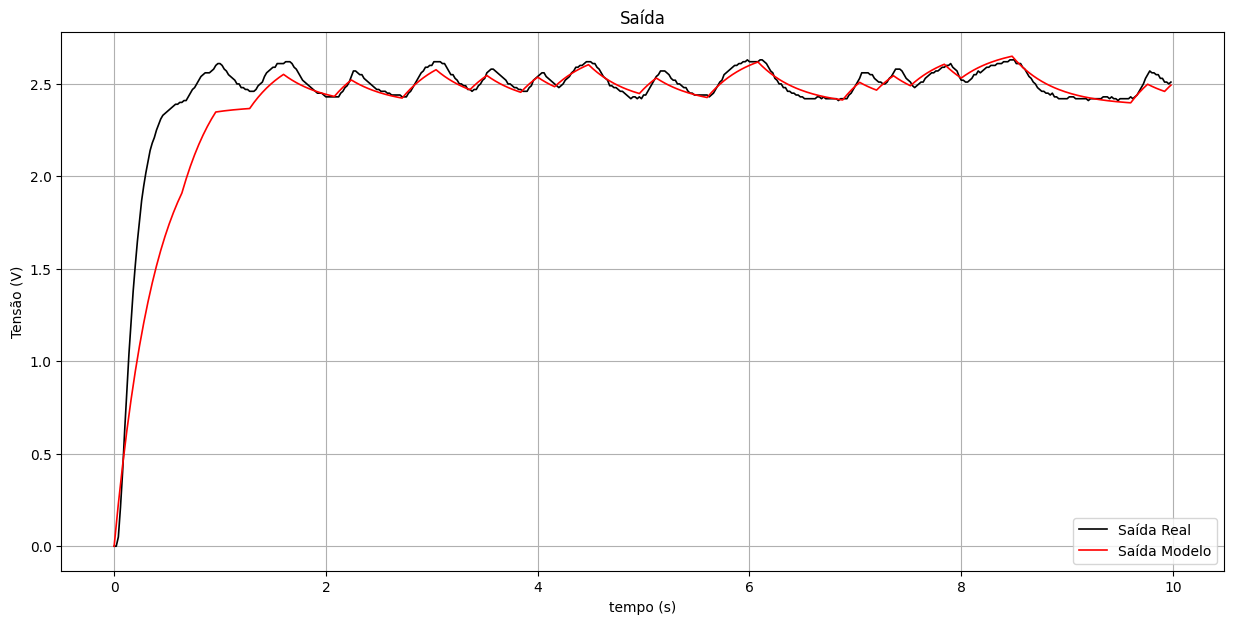

In [ ]:
y_saida_PRBS = ct.forced_response(Gz_PRBS, U=sinal_entrada_PRBS)[1]

plt.figure(figsize=(15,7))
plt.plot(tempo_PRBS, sinal_saida_PRBS, '-k', linewidth=1.2)
plt.plot(tempo_PRBS, y_saida_PRBS, '-r', linewidth=1.2)
plt.xlabel('tempo (s)')
plt.ylabel('Tensão (V)')
plt.title('Saída')
plt.legend(loc='lower right', labels=('Saída Real', 'Saída Modelo'))
plt.grid()

plt.subplots_adjust(hspace=0.5)
plt.show()

Período de Amostragem: 0.01999999999999975

 G(z)= 
 -0.0005045 z + 0.01967
------------------------
z^2 - 0.9527 z + 0.01299

dt = 0.01999999999999975



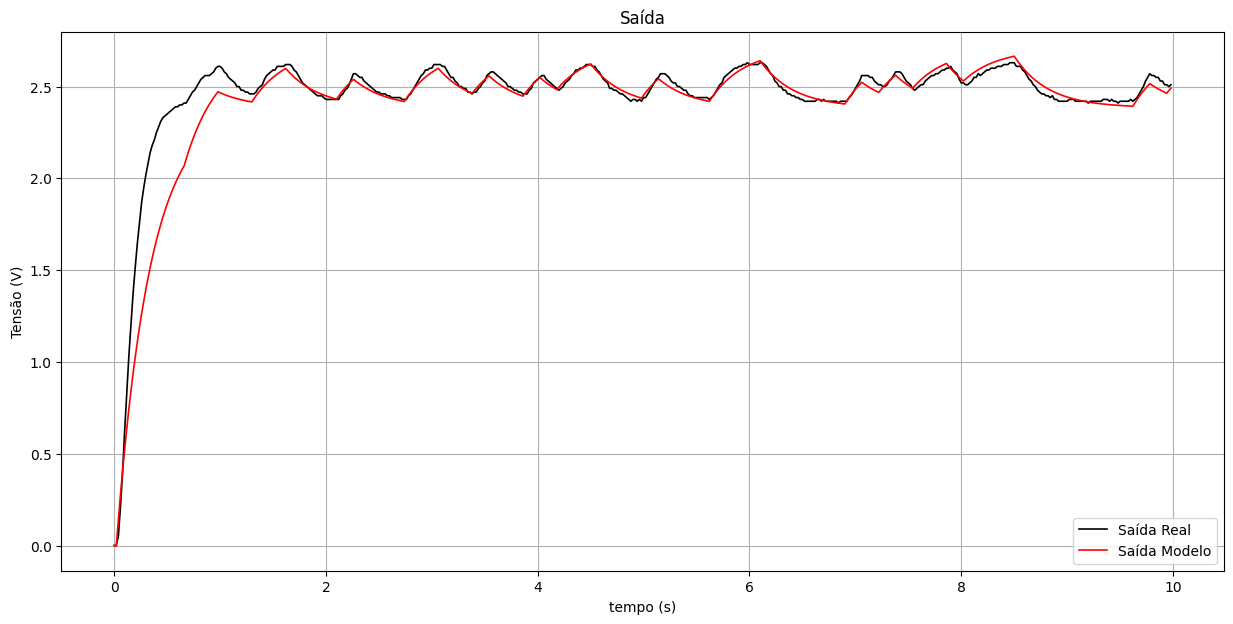

In [ ]:
# Matriz de Regressores (Segunda Ordem)
PSI_PRBS = np.array([-ytrain_PRBS[k_PRBS - 1], -ytrain_PRBS[k_PRBS - 2], xtrain_PRBS[k_PRBS - 1], xtrain_PRBS[k_PRBS - 2]]).T

# Passo
# Calculo dos coeficientes
teta_PRBS = np.linalg.inv(PSI_PRBS.T @ PSI_PRBS) @ PSI_PRBS.T@ytrain_PRBS[k_PRBS]

# Passo
# Separando os coeficientes
a1_PRBS, a2_PRBS, b1_PRBS, b2_PRBS = teta_PRBS

# Numerador de H(z)
B_PRBS = [b1_PRBS, b2_PRBS]

# Denominador de H(z)
A_PRBS = [1, a1_PRBS, a2_PRBS]

# Período de amostragem em segundos
Ts_PRBS = np.mean(np.diff(tempo_PRBS))
print('Período de Amostragem:', Ts_PRBS)

# Função de transferência pulsada
Gz2_PRBS = ct.tf(B_PRBS, A_PRBS, Ts_PRBS)
print("\n","G(z)=", Gz2_PRBS)

# Passo
# Respostas da função de transferência para a entrada de validação.
y_hat_PRBS = ct.forced_response(Gz2_PRBS, U=xtest_PRBS)[1]

# Calculo do EQM comparando os dados observados com preditos.
#MSE = mean_squared_error(ytest[50:], y_hat[50:])
#print('Erro médio quadrático: %.6f' % MSE)

y_saida_PRBS = ct.forced_response(Gz2_PRBS, U=sinal_entrada_PRBS)[1]

plt.figure(figsize=(15,7))
plt.plot(tempo_PRBS, sinal_saida_PRBS, '-k', linewidth=1.2)
plt.plot(tempo_PRBS, y_saida_PRBS, '-r', linewidth=1.2)

plt.xlabel('tempo (s)')
plt.ylabel('Tensão (V)')
plt.title('Saída')
plt.legend(loc='lower right', labels=('Saída Real', 'Saída Modelo'))
plt.grid()
plt.show()

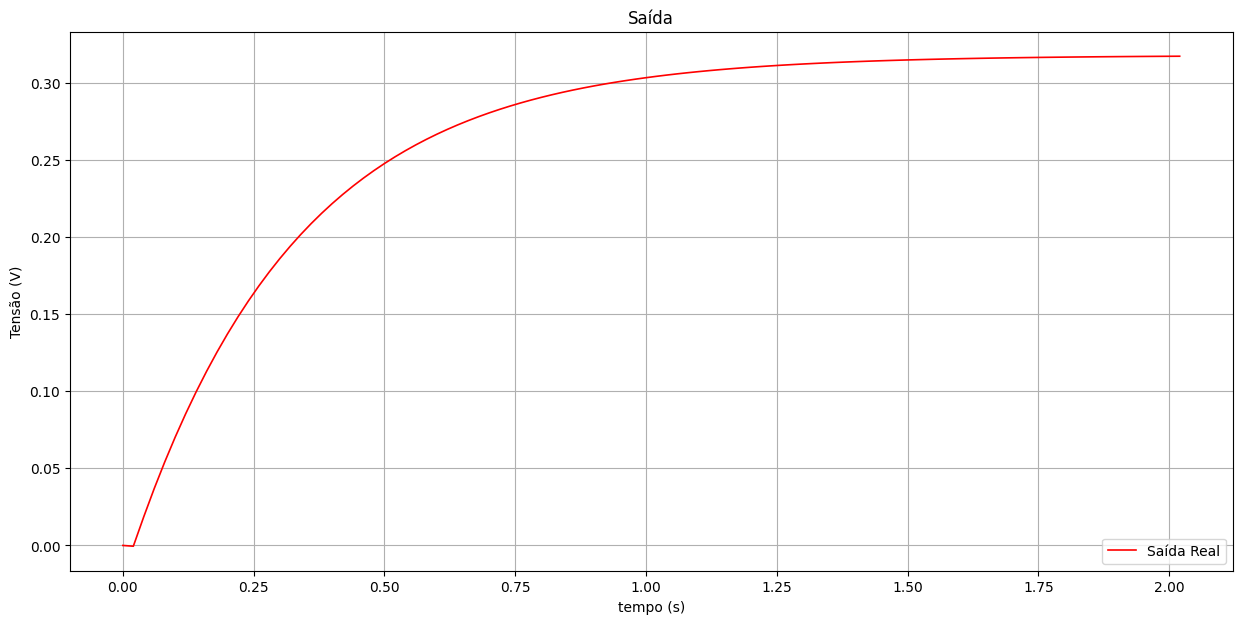

In [ ]:
t_PRBS,y_step_PRBS = ct.step_response(Gz2_PRBS, T = 2)

plt.figure(figsize=(15,7))
plt.plot(t_PRBS, y_step_PRBS, '-r', linewidth=1.2)
plt.xlabel('tempo (s)')
plt.ylabel('Tensão (V)')
plt.title('Saída')
plt.legend(loc='lower right', labels=('Saída Real', 'Saída Modelo'))
plt.grid()
plt.show()

#Controlador P PRBS

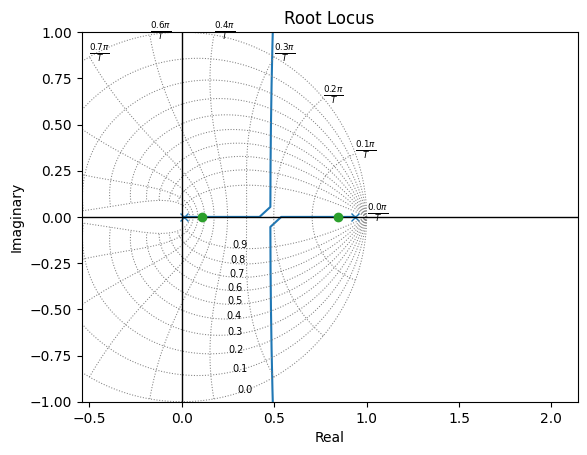

In [ ]:
#Controlador P:
Kp_PRBS = 4.1
Gz_MF_PRBS = ct.feedback(Gz2_PRBS * Kp_PRBS,1)
ct.root_locus(Gz2_PRBS * Kp_PRBS, kvect = np.linspace(0,80,1000));
# ct.root_locus(G, kvect = np.linspace(0,12,1000));
plt.plot(Gz_MF_PRBS.pole().real,Gz_MF_PRBS.pole().imag, 'o')
plt.axis([0.5,1.1, -1, 1]);

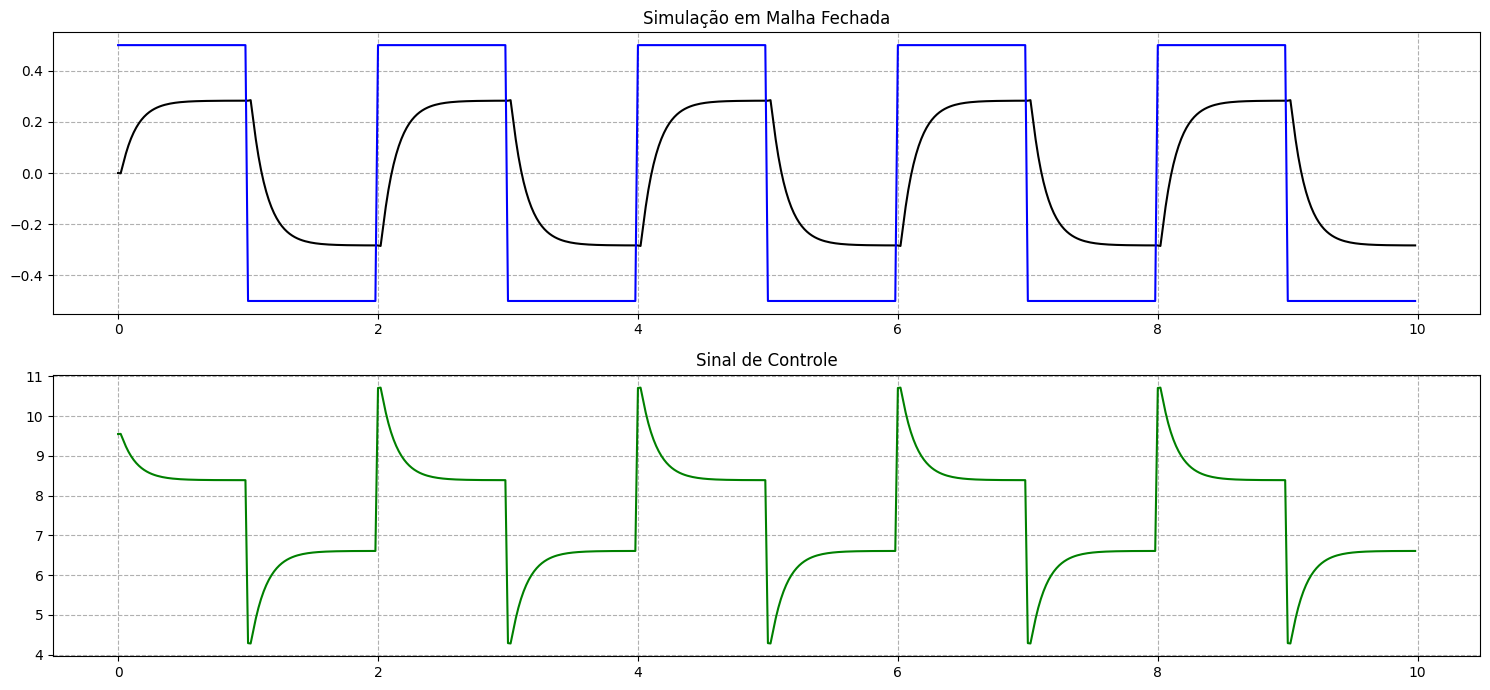

In [ ]:
C_p_PRBS = ct.feedback(Kp_PRBS, Gz2_PRBS, sign = -1)

_, ymf_p_PRBS = ct.forced_response(Gz_MF_PRBS, T = tempo_Continuo, U = r_Continuo * 1/2)
_, u_p_PRBS = ct.forced_response(C_p_PRBS,T = tempo_Continuo, U = r_Continuo * 1/2)

plt.figure(figsize=(15,7))
plt.subplot(2, 1, 1)
plt.plot(tempo_Continuo, ymf_p_PRBS , 'k')
plt.plot(tempo_Continuo, r_Continuo * 1/2, 'b')

plt.title("Simulação em Malha Fechada")
plt.grid(linestyle='--')

plt.subplot(2, 1, 2)
plt.plot(tempo_Continuo, u_p_PRBS+7.5, 'g')
plt.title("Sinal de Controle")
plt.grid(linestyle='--')

plt.tight_layout()
plt.show()

**SINAL OBTIDO DO CONTROLADOR P PRBS**

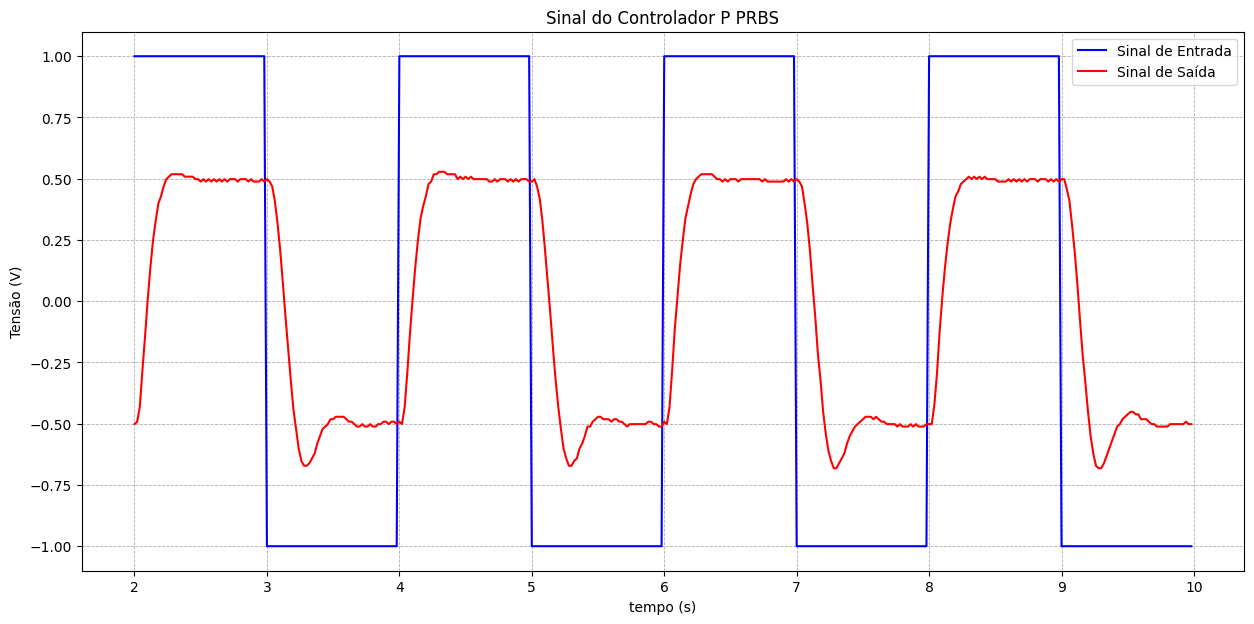

In [ ]:
dados_PRBS_P = np.load(r'/content/drive/MyDrive/Bancada_5/Dados_dos_Controladores/Dados_Controlador_P_PRBS.np.npy')

tempo_PRBS_P = dados_PRBS_P[:,0]
sinal_entrada_PRBS_P  = dados_PRBS_P[:,1]
sinal_saida_PRBS_P = dados_PRBS_P[:,2]

nivel_dc_entrada_PRBS_P = np.mean(sinal_entrada_PRBS_P[janela_Continuo])

nivel_dc_saida_PRBS_P = np.mean(sinal_saida_PRBS_P[janela_Continuo])

# ________________ Remove Nivel DC da Entrada e da Saída __________#

r_PRBS_P = sinal_entrada_PRBS_P - nivel_dc_entrada_PRBS_P
y_PRBS_P = sinal_saida_PRBS_P - nivel_dc_saida_PRBS_P

plt.figure(figsize=(15,7))
plt.plot(tempo_PRBS_P[janela_Continuo],r_PRBS_P[janela_Continuo], c = 'b', label = "Sinal de Entrada")
plt.plot(tempo_PRBS_P[janela_Continuo],y_PRBS_P[janela_Continuo], c = 'r', label = "Sinal de Saída")

plt. title('Sinal do Controlador P PRBS')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)
plt.show()

#Controlador PI PRBS

TransferFunction(array([ 4.4, -3.6]), array([ 1., -1.]), 0.02)

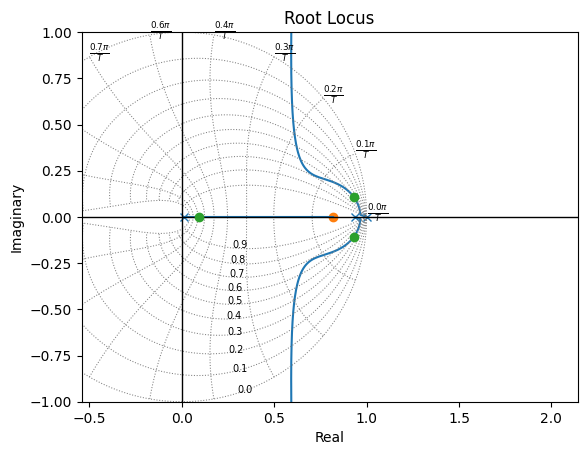

In [ ]:
#Controlador PI:
dt = 0.02

K_PI_PRBS = 4
a_PI_PRBS = 10

num_PI_PRBS = np.array([K_PI_PRBS ,K_PI_PRBS * a_PI_PRBS])
den_PI_PRBS = np.array([1, 0])

Kpi_PRBS = ct.tf(num_PI_PRBS, den_PI_PRBS)

Kpiz_PRBS = ct.c2d(Kpi_PRBS, dt, 'tustin')
Gz_MF_PI_PRBS = ct.feedback(Gz2_PRBS * Kpiz_PRBS, 1)
ct.root_locus(Gz2_PRBS * Kpiz_PRBS, kvect = np.linspace(0,80,1000));

plt.plot(Gz_MF_PI_PRBS.pole().real,Gz_MF_PI_PRBS.pole().imag, 'o')
plt.axis([0.5,1.1, -1, 1]);

display(Kpiz_PRBS)

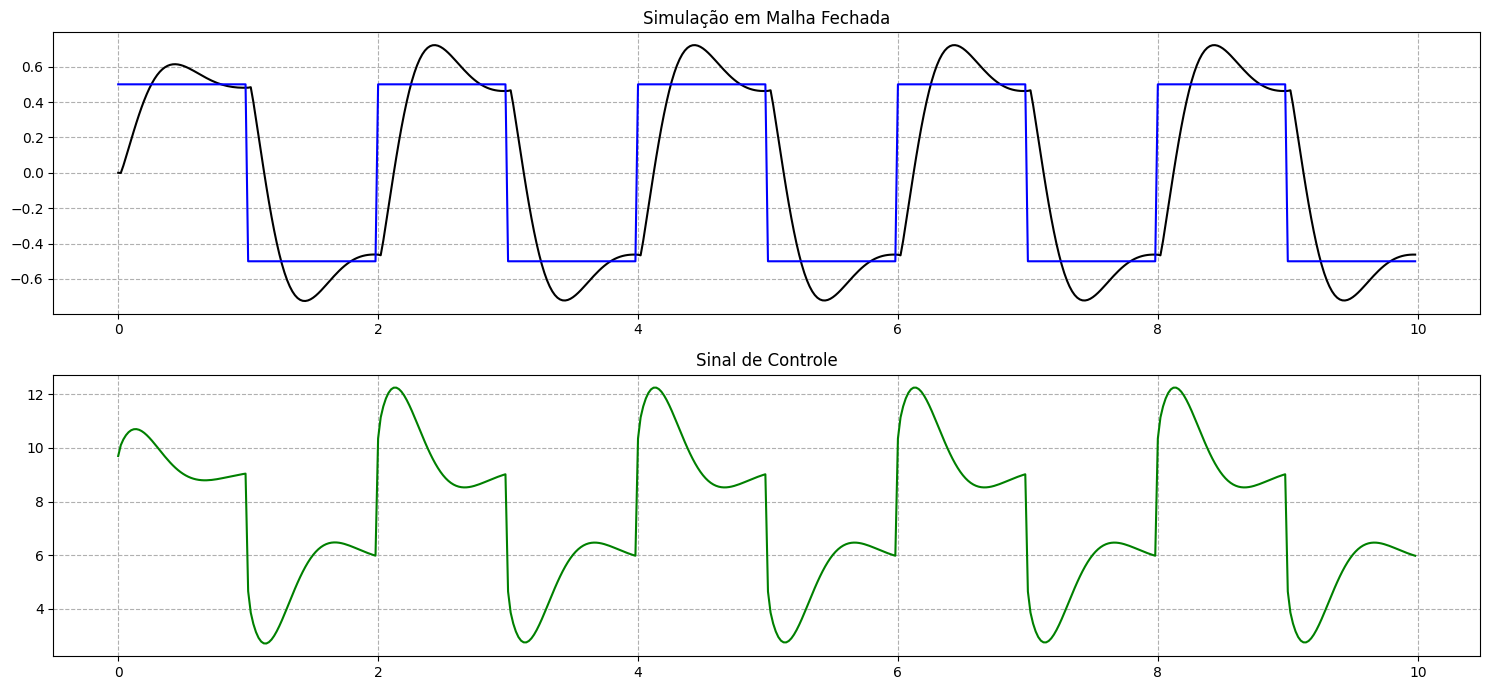

In [ ]:
C_pi = ct.feedback(Kpiz_PRBS, Gz2_PRBS, sign = -1)

_, ymf_pi_PRBS = ct.forced_response(Gz_MF_PI_PRBS, T = tempo_Continuo, U = r_Continuo*1/2)
_, u_pi_PRBS = ct.forced_response(C_pi,T = tempo_Continuo, U = r_Continuo*1/2)

plt.figure(figsize=(15,7))
plt.subplot(2, 1, 1)
plt.plot(tempo_Continuo, ymf_pi_PRBS , 'k')
plt.plot(tempo_Continuo, r_Continuo*1/2, 'b')
plt.title("Simulação em Malha Fechada")
plt.grid(linestyle='--')

plt.subplot(2, 1, 2)
plt.plot(tempo_Continuo, u_pi_PRBS + 7.5, 'g')
plt.title("Sinal de Controle")
plt.grid(linestyle='--')

plt.tight_layout()
plt.show()

# MÉTODO ZIEGLER

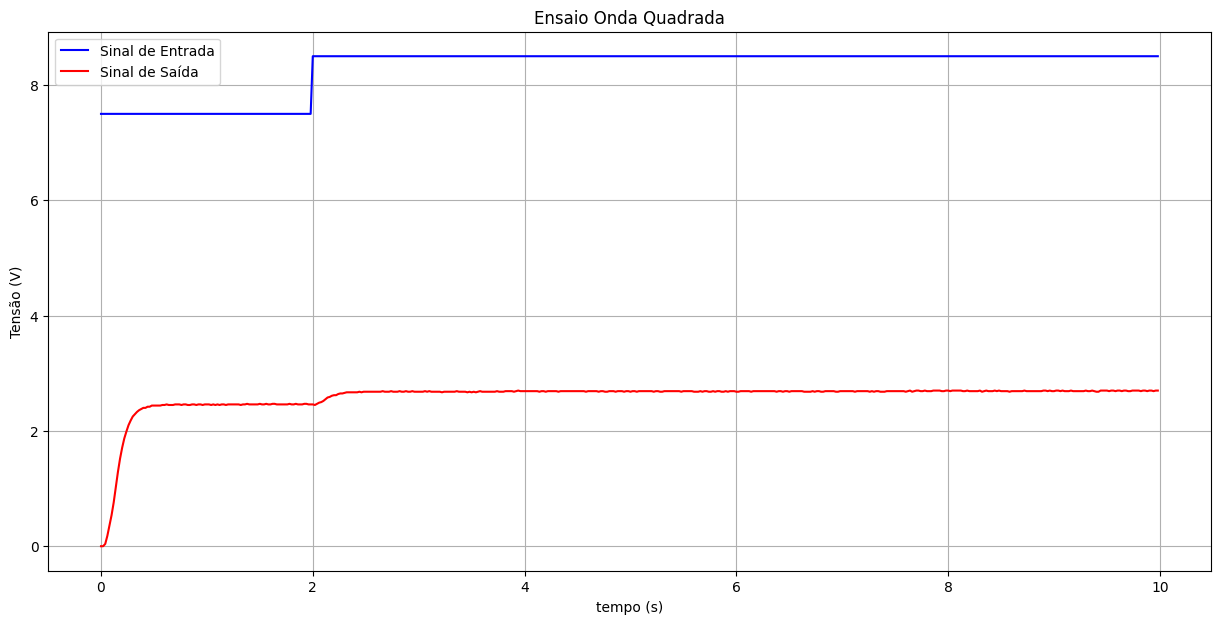


 Nivel DC de Saída 2.594


In [ ]:
dados_Ziegler = np.load(r'/content/drive/MyDrive/Bancada_5/Dados_Coletados/Dados_Coletados_Ziegler.npy')

tempo_Ziegler = dados_Ziegler[:,0]
sinal_entrada_Ziegler  = dados_Ziegler[:,1]
sinal_saida_Ziegler = dados_Ziegler[:,2]

plt.figure(figsize=(15,7))
plt.plot(tempo_Ziegler,sinal_entrada_Ziegler, c = 'b', label = "Sinal de Entrada")
plt.plot(tempo_Ziegler,sinal_saida_Ziegler, c = 'r', label = "Sinal de Saída")

plt. title('Ensaio Onda Quadrada')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid()
plt.show()

nivel_DC_saida_Ziegler = np.mean(sinal_saida_Ziegler)
nivel_DC_entrada_Ziegler = np.mean(sinal_entrada_Ziegler)

print('\n Nivel DC de Saída', np.round(nivel_DC_saida_Ziegler, 3))

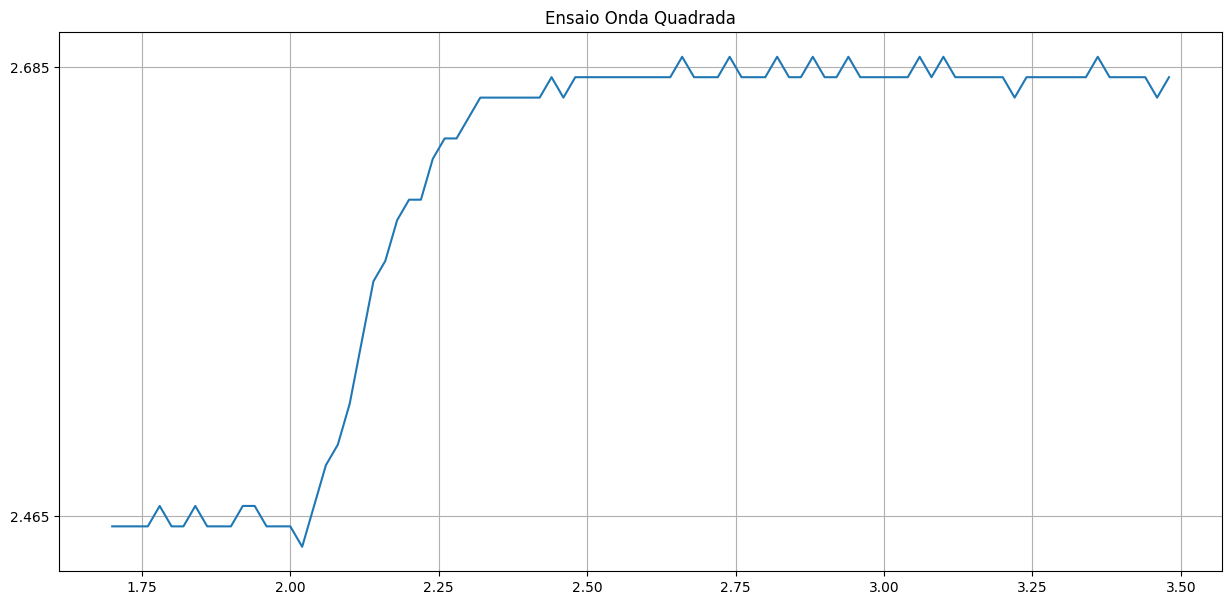

In [ ]:
janela = (tempo_Ziegler>1.7) & (tempo_Ziegler<3.5)
plt.figure(figsize=(15,7))
plt.plot(tempo_Ziegler[janela],sinal_saida_Ziegler[janela])
plt. title('Ensaio Onda Quadrada')
# plt.xticks([1.95,2.05,2.246])
plt.yticks([2.465,2.685])
plt.grid()
plt.show()

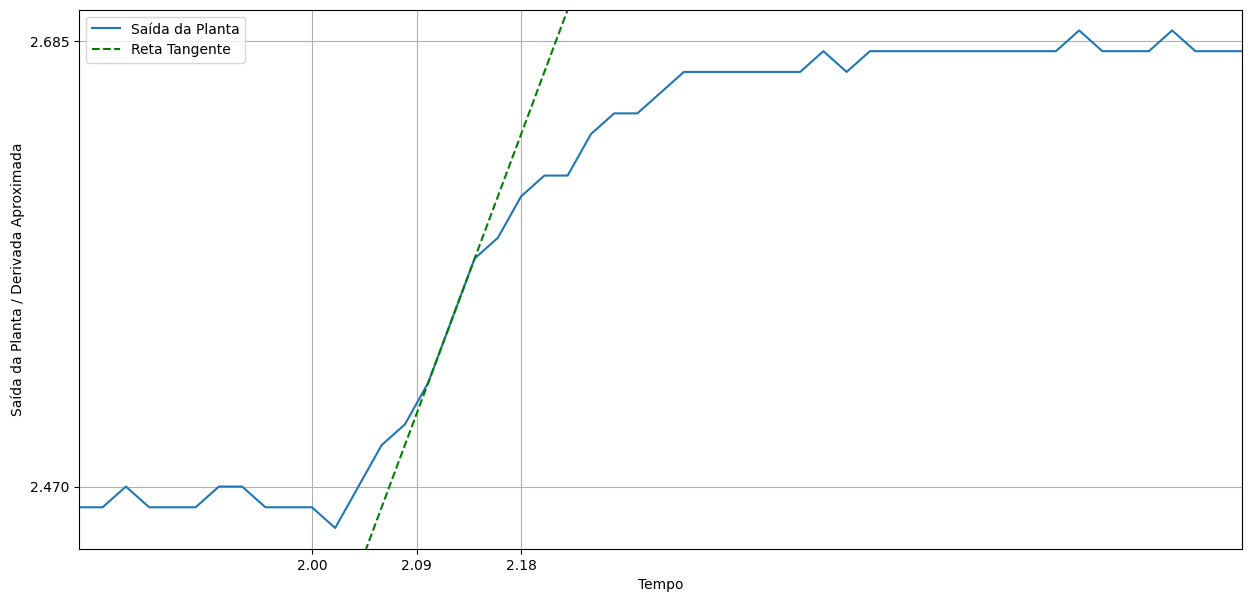

In [ ]:
# Dados de exemplo
saida_planta = sinal_saida_Ziegler[janela]

tempo_planta = tempo_Ziegler[janela]

# Calculando a derivada usando diferença finita
derivada_aproximada = np.diff(saida_planta) / np.diff(tempo_planta)

indice_max_derivada = np.argmax(derivada_aproximada)

reta_tangente = np.poly1d(np.polyfit(tempo_planta[indice_max_derivada:indice_max_derivada+2],
                                     saida_planta[indice_max_derivada:indice_max_derivada+2], 1))

plt.figure(figsize=(15, 7))
plt.plot(tempo_planta, saida_planta, label='Saída da Planta')
plt.plot(tempo_planta, reta_tangente(tempo_planta), '--', color='green', label='Reta Tangente')

plt.xlabel('Tempo')
plt.ylabel('Saída da Planta / Derivada Aproximada')
plt.yticks([2.47,2.685])
plt.xticks([2,2.09,2.18])
plt.ylim([2.44,2.7])
plt.xlim([1.8,2.8])
plt.legend()
plt.grid()

In [ ]:
K_Ziegler = 2.685-2.470
L_Ziegler = 2.09-2
T_Ziegler = 2.18-2.09

#Controlador P
Kp_Ziegler  = T_Ziegler / (K_Ziegler * L_Ziegler)

#Controlador PI
Kp1_Ziegler = (0.9 * T_Ziegler) / (K_Ziegler * L_Ziegler)
T1_Ziegler = 3*L_Ziegler

print('Kp', np.round(Kp_Ziegler,3))

print('\nKp1', np.round(Kp1_Ziegler,3))
print('T1', np.round(T1_Ziegler,3))

Kp 4.651

Kp1 4.186
T1 0.27


**CONTROLADOR P ZIEGLER**

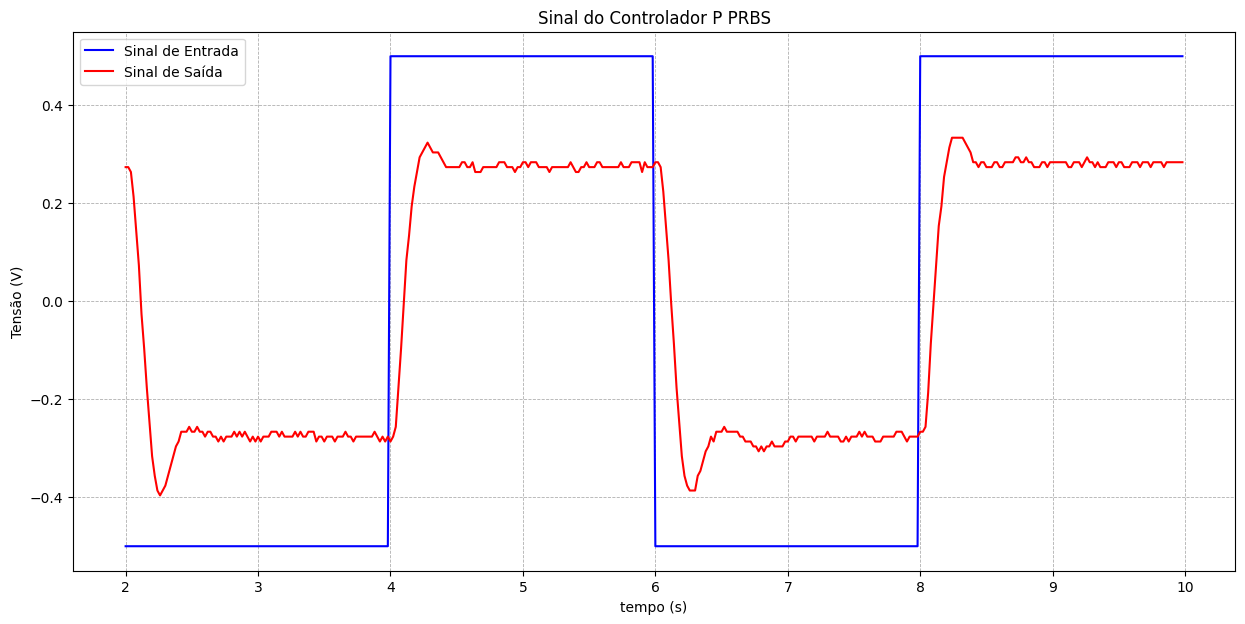

In [ ]:
dados_Ziegler_P = np.load(r'/content/drive/MyDrive/Bancada_5/Dados_dos_Controladores/Dados_Controlador_P_Ziegler.np.npy')

tempo_Ziegler_P = dados_Ziegler_P[:,0]
sinal_entrada_Ziegler_P  = dados_Ziegler_P[:,1]
sinal_saida_Ziegler_P = dados_Ziegler_P[:,2]

nivel_dc_entrada_Ziegler_P = np.mean(sinal_entrada_Ziegler_P[janela_Continuo])

nivel_dc_saida_Ziegler_P = np.mean(sinal_saida_Ziegler_P[janela_Continuo])

# ________________ Remove Nivel DC da Entrada e da Saída __________#

r_Ziegler_P = sinal_entrada_Ziegler_P - nivel_dc_entrada_Ziegler_P
y_Ziegler_P = sinal_saida_Ziegler_P - nivel_dc_saida_Ziegler_P

plt.figure(figsize=(15,7))
plt.plot(tempo_Ziegler_P[janela_Continuo],r_Ziegler_P[janela_Continuo], c = 'b', label = "Sinal de Entrada")
plt.plot(tempo_Ziegler_P[janela_Continuo],y_Ziegler_P[janela_Continuo], c = 'r', label = "Sinal de Saída")

plt. title('Sinal do Controlador P Ziegler')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)
plt.show()

**CONTROLADOR PI ZIEGLER**

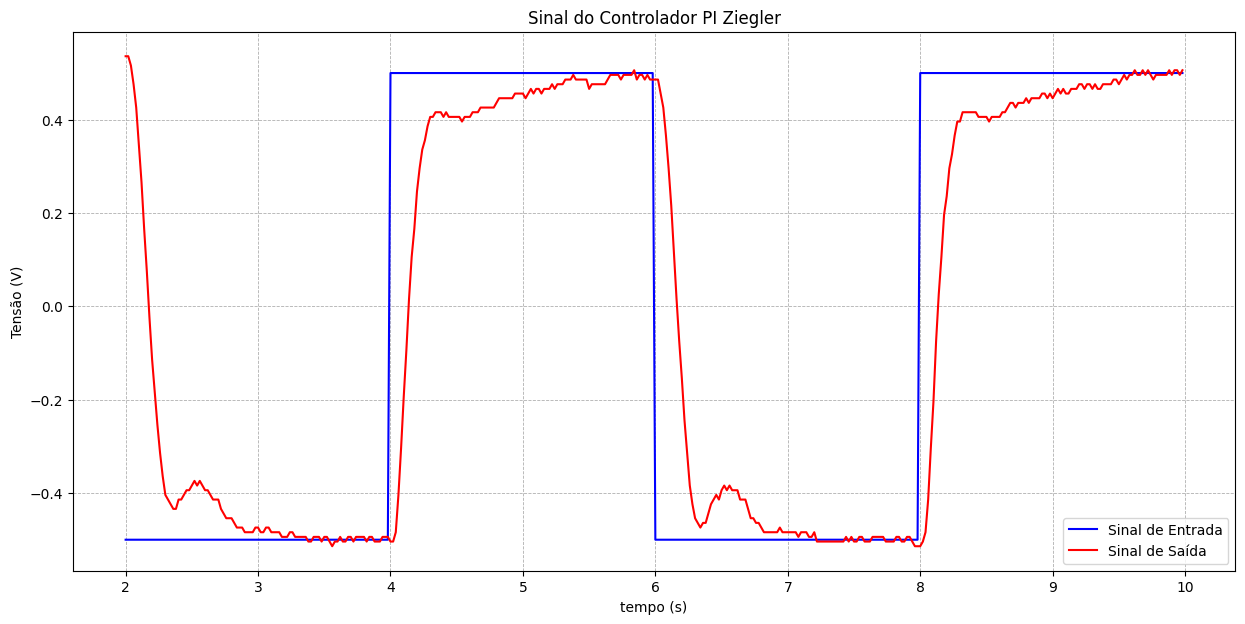

In [ ]:
dados_Ziegler_PI = np.load(r'/content/drive/MyDrive/Bancada_5/Dados_dos_Controladores/Dados_Controlador_PI_Ziegler.np.npy')

tempo_Ziegler_PI = dados_Ziegler_PI[:,0]
sinal_entrada_Ziegler_PI  = dados_Ziegler_PI[:,1]
sinal_saida_Ziegler_PI = dados_Ziegler_PI[:,2]

nivel_dc_entrada_Ziegler_PI = np.mean(sinal_entrada_Ziegler_PI[janela_Continuo])

nivel_dc_saida_Ziegler_PI = np.mean(sinal_saida_Ziegler_PI[janela_Continuo])

# ________________ Remove Nivel DC da Entrada e da Saída __________#

r_Ziegler_PI = sinal_entrada_Ziegler_PI - nivel_dc_entrada_Ziegler_PI
y_Ziegler_PI = sinal_saida_Ziegler_PI - nivel_dc_saida_Ziegler_PI

plt.figure(figsize=(15,7))
plt.plot(tempo_Ziegler_PI[janela_Continuo],r_Ziegler_PI[janela_Continuo], c = 'b', label = "Sinal de Entrada")
plt.plot(tempo_Ziegler_PI[janela_Continuo],y_Ziegler_PI[janela_Continuo], c = 'r', label = "Sinal de Saída")

plt. title('Sinal do Controlador PI Ziegler')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6)
plt.show()